In [271]:
import pandas as pd

In [272]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import expr
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt
sc = SparkSession.builder.appName('SparkByExamples.com').getOrCreate()
sc

In [64]:
df = spark.read.csv(
    "US_tradematrix.csv", 
    header=True)\
.withColumnRenamed("Economy Label","Economy_Label")\
.withColumnRenamed("Partner Label","Partner_Label")\
.withColumnRenamed("Flow Label","Flow_Label")\
.withColumnRenamed("SitcRev3Product Label","SitcRev3Product_Label")\
.withColumnRenamed("US dollars at current prices in thousands","price")\
.withColumnRenamed("US dollars at current prices in thousands Footnote","price_footnote")
df = df.withColumn('price', df.price.cast(IntegerType()))


In [65]:
df.show(1)

+----+-------+-------------+-------+-------------+----+----------+---------------+---------------------+----------+--------------+
|Year|Economy|Economy_Label|Partner|Partner_Label|Flow|Flow_Label|SitcRev3Product|SitcRev3Product_Label|     price|price_footnote|
+----+-------+-------------+-------+-------------+----+----------+---------------+---------------------+----------+--------------+
|2016|   0000|        World|   0000|        World|  01|   Imports|              0| Food and live ani...|1067922054|          null|
+----+-------+-------------+-------+-------------+----+----------+---------------+---------------------+----------+--------------+
only showing top 1 row



In [49]:
%%time
# world trade trend

df.where(df.Economy_Label == 'World').groupby(['Flow Label','Year']).sum('price').orderBy(['Flow Label','Year']).show(10)

+----------+----+-------------+
|Flow Label|Year|   sum(price)|
+----------+----+-------------+
|   Exports|2016|3405154409641|
|   Exports|2017|3663528018901|
|   Exports|2018|3872726964013|
|   Exports|2019|3811337406439|
|   Exports|2020|3641919444863|
|   Imports|2016|3375470539812|
|   Imports|2017|3676872205562|
|   Imports|2018|3882593546203|
|   Imports|2019|3801345795923|
|   Imports|2020|3636650170512|
+----------+----+-------------+

Wall time: 1min 41s


In [102]:
# searching for country names
country_names = df.select(col('Economy_Label')).drop_duplicates().toPandas()

In [148]:
country_names[country_names.Economy_Label.str.contains('Asia')]

,Economy_Label
9,Western Asia and Northern Africa
18,ASEAN (Association of Southeast Asian Nations)...
29,Emerging markets: Asia
43,ESCAP (Economic and Social Commission for Asia...
47,Developing economies: Asia
52,ASEAN (Association of Southeast Asian Nations)
80,Developed economies: Asia
88,APEC (Asia-Pacific Economic Cooperation)
136,"UNECE: Eastern Europe, Caucasus and Central Asia"
138,Central Asia


In [92]:
# Austria
austria_df = df.where(df.Economy_Label == 'Austria').groupby(['Economy_Label','Flow_Label','Year','SitcRev3Product_Label', 'Partner_Label']).sum('price').orderBy(['Flow_Label','Year']).toPandas()


In [112]:
us_df = df.where(df.Economy_Label == 'United States of America').groupby(['Economy_Label','Flow_Label','Year','SitcRev3Product_Label', 'Partner_Label']).sum('price').orderBy(['Flow_Label','Year']).toPandas()

In [133]:
# find strings
products = df.select(col('SitcRev3Product_Label')).drop_duplicates().toPandas()


In [276]:
products[products.SitcRev3Product_Label.str.contains('paper', case = False)].iloc[1,0]

,SitcRev3Product_Label
81,Paper and paper manufactures
241,"Paper & paperboard, cut to shape or size, arti..."
272,Paper and paperboard
332,Pulp and waste paper
372,"Paper mill, pulp mill machinery; paper article..."


In [280]:
products.to_csv('full_product_list.csv',index = False)

In [281]:
products[products.SitcRev3Product_Label.str.contains('paper', case = False)]

,SitcRev3Product_Label
81,Paper and paper manufactures
241,"Paper & paperboard, cut to shape or size, arti..."
272,Paper and paperboard
332,Pulp and waste paper
372,"Paper mill, pulp mill machinery; paper article..."


In [139]:
plastic_products = products[products.SitcRev3Product_Label.str.contains('plastic', regex = True, case = False)].copy()
plastic_products['class'] = 'plastic'
bag_products = products[products.SitcRev3Product_Label.str.contains('bag', regex = True, case = False)].copy()
bag_products['class'] = 'bag'
film_products = products[products.SitcRev3Product_Label.str.contains('film', regex = True, case = False)].copy()
film_products['class'] = 'film'
combined_products = pd.concat([plastic_products, bag_products, film_products])
combined_products = combined_products.rename(columns = {'SitcRev3Product_Label':'product_name'})
combined_products

,product_name,class
37,"Waste, parings and scrap, of plastics",plastic
45,Plastics in non-primary forms,plastic
52,Plastics in primary forms,plastic
53,"Tubes, pipes and hoses of plastics",plastic
259,"Other plastics, in primary forms",plastic
266,"Plates, sheets, films, foil & strip, of plastics",plastic
294,"Monofilaments, of plastics, cross-section > 1mm",plastic
328,"Articles, n.e.s., of plastics",plastic
59,"Travel goods, handbags & similar containers",bag
299,"Travel goods, handbags, etc.",bag


In [254]:
volume = smaller_df.groupby('SitcRev3Product_Label').sum('price').toPandas()

In [262]:
volume

,SitcRev3Product_Label,sum(price)
0,"Waste, parings and scrap, of plastics",758867330
1,Plastics in non-primary forms,25635520254
2,Plastics in primary forms,50069307016
3,"Tubes, pipes and hoses of plastics",5062175070
4,"Travel goods, handbags & similar containers",13831463984
5,"Cinematograph films, exposed & developed",1578194
6,"Other plastics, in primary forms",20697542998
7,"Plates, sheets, films, foil & strip, of plastics",19376435272
8,"Monofilaments, of plastics, cross-section > 1mm",1196897260
9,"Travel goods, handbags, etc.",13831463984


In [263]:
volume[volume.SitcRev3Product_Label.isin(['Plastics in non-primary forms', 'Plastics in primary forms', 'Articles, n.e.s., of plastics']) == False]['sum(price)'].sum()

74756424092

In [261]:
volume[volume.SitcRev3Product_Label.isin(['Plastics in non-primary forms', 'Plastics in primary forms']) == True]['sum(price)'].sum()

75704827270

In [175]:
combined_products.to_csv('product_info.csv')
print('product info saved')

product info saved


In [ ]:
'''
product specific information:

--plastics:
Other plastics, in primary forms
Articles, n.e.s., of plastics
Monofilaments, of plastics, cross-section > 1mm
Plastics in non-primary forms
Plastics in primary forms
Tubes, pipes and hoses of plastics
Waste, parings and scrap, of plastics
Plates, sheets, films, foil & strip, of plastics

--bags:
Travel goods, handbags & similar containers
Travel goods, handbags, etc.

--film:
Plates, sheets, films, foil & strip, of plastics

'''

['Waste, parings and scrap, of plastics',
 'Plastics in non-primary forms',
 'Plastics in primary forms',
 'Tubes, pipes and hoses of plastics',
 'Other plastics, in primary forms',
 'Plates, sheets, films, foil & strip, of plastics',
 'Monofilaments, of plastics, cross-section > 1mm',
 'Articles, n.e.s., of plastics',
 'Travel goods, handbags & similar containers',
 'Travel goods, handbags, etc.',
 'Cinematograph films, exposed & developed',
 'Plates, sheets, films, foil & strip, of plastics']

# query the necessary data

In [155]:
country_list = ['United States of America', 'China', 'India','Europe']
product_list = list(combined_products.product_name.values)
smaller_df = df.filter(df.SitcRev3Product_Label.isin(product_list))\
.filter(df.Economy_Label.isin(country_list)).persit()
output = smaller_df.groupby(['Economy_Label','Flow_Label','Year','SitcRev3Product_Label', 'Partner_Label']).sum('price').orderBy(['Flow_Label','Year']).toPandas()
output = output.rename(columns = {'sum(price)':'total_values'})
output.to_csv('yearly_flow_data_by_countries.csv', index = False)
print('output saved!')

output saved!


In [174]:
output.groupby('Economy_Label').apply(lambda x: x.Partner_Label.value_counts(normalize = True).reset_index().iloc[0,:])

,index,Partner_Label
Economy_Label,,
China,Asia and Oceania,0.003126
Europe,Developed economies: Asia and Oceania,0.002572
India,BioTrade countries,0.003230
United States of America,NAFTA (North American Free Trade Agreement),0.003081


# trade partner analysis

In [217]:
country_list = ['United States of America', 'China', 'Asia','India','Europe', 'Austria', 'German']
partner = pd.read_csv('US_partner.csv')
partner = partner[partner['Economy Label'].isin(country_list)]


C:\Users\yzp60\anaconda3\envs\DSCI553\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [198]:
partner.head()

,Year,Economy,Economy Label,Partner,Partner Label,Flow,Flow Label,Product,Product Label,US dollars at current prices in thousands,US dollars at current prices in thousands Footnote
30449,1995,156,China,0,World,1,Imports,P_00,Total plastics,1.562935e+07,NaN
30450,1995,156,China,0,World,1,Imports,P_01,Plastics in primary forms,6.303396e+06,NaN
30451,1995,156,China,0,World,1,Imports,P_02,Intermediate forms of plastic,3.039465e+06,NaN
30452,1995,156,China,0,World,1,Imports,P_03,Intermediate manufactured plastic goods,5.062039e+06,NaN
30453,1995,156,China,0,World,1,Imports,P_04,Final manufactured plastics goods,1.108457e+06,NaN


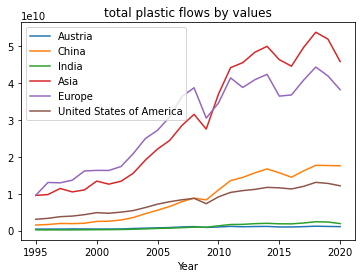

In [223]:
for country in partner['Economy Label'].unique():
    partner[(partner['Economy Label'] == country)]\
    .groupby('Year')['US dollars at current prices in thousands'].sum().plot.line()
plt.legend(partner['Economy Label'].unique())
plt.title('total plastic flows by values')
plt.show()

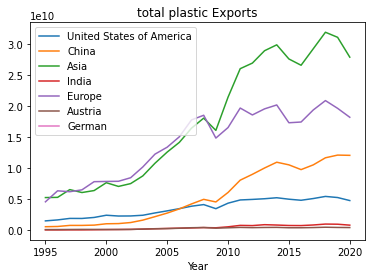

In [224]:
for country in country_list:
    partner[(partner['Economy Label'] == country)&(partner['Flow Label'] == 'Exports')]\
    .groupby('Year')['US dollars at current prices in thousands'].sum().plot.line()
plt.legend(country_list)
plt.title('total plastic Exports')
plt.show()

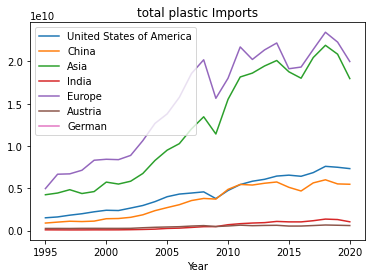

In [225]:
for country in country_list:
    partner[(partner['Economy Label'] == country)&(partner['Flow Label'] == 'Imports')]\
    .groupby('Year')['US dollars at current prices in thousands'].sum().plot.line()
plt.legend(country_list)
plt.title('total plastic Imports')
plt.show()

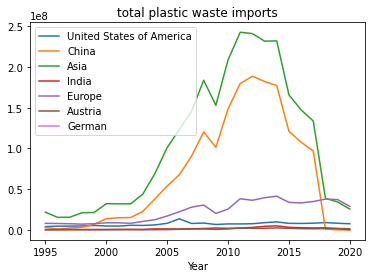

In [226]:
for country in country_list:
    partner[(partner['Economy Label'] == country)\
            &(partner['Flow Label'] == 'Imports')\
            &(partner['Product'] == 'P_05')]\
    .groupby('Year')['US dollars at current prices in thousands'].sum().plot.line()
plt.legend(country_list)
plt.title('total plastic waste imports')
plt.show()

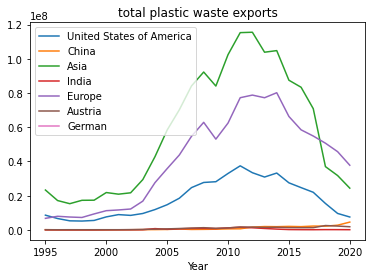

In [227]:
for country in country_list:
    partner[(partner['Economy Label'] == country)\
            &(partner['Flow Label'] == 'Exports')\
            &(partner['Product'] == 'P_05')]\
    .groupby('Year')['US dollars at current prices in thousands'].sum().plot.line()
plt.legend(country_list)
plt.title('total plastic waste exports')
plt.show()

C:\Users\yzp60\anaconda3\envs\DSCI553\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


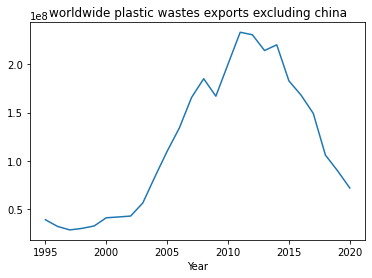

In [270]:
all_partner = pd.read_csv('US_partner.csv')
partner[(partner['Economy Label'] != 'China')\
        &(partner['Flow Label'] == 'Exports')\
        &(partner['Product'] == 'P_05')]\
.groupby('Year')['US dollars at current prices in thousands'].sum().plot.line()

plt.title('worldwide plastic wastes exports excluding china')
plt.show()